<a href="https://colab.research.google.com/github/Sneya9205/Recommendation_System/blob/main/2022506062_SneyaGabreate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommendation System 1: Content-Based Movie Similarity Using TensorFlow: Finding Similar Movies with Title Embeddings

Install and Import

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.6 MB/s eta 0:00:00


Loading the data

In [ ]:
# Load movie metadata.
movies = tfds.load('movielens/100k-movies', split="train")

# Extract movie titles.
movies = movies.map(lambda x: x["movie_title"])

# Create movie title vocabulary.
movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.FVLRDD_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


Model Definition

In [ ]:
class MovieSimilarityModel(tf.keras.Model):
    def __init__(self, movie_model):
        super().__init__()
        self.movie_model = movie_model

    def call(self, inputs):
        # Get embeddings for movie titles.
        movie_embeddings = self.movie_model(inputs)
        # Normalize embeddings for cosine similarity.
        normalized_embeddings = tf.math.l2_normalize(movie_embeddings, axis=1)
        return normalized_embeddings

# Movie model using embeddings.
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocabulary_size(), 64)
])

# Create similarity model instance.
similarity_model = MovieSimilarityModel(movie_model)


Evaluation

In [ ]:
# Sample query movie title.
query_movie = np.array(["From Dusk Till Dawn (1996)"])

# Embedding function for the query.
query_embeddings = similarity_model(query_movie)

# Calculate similarity scores using cosine similarity.
similarity_scores = tf.linalg.matmul(query_embeddings, tf.transpose(similarity_model.movie_model.weights[1]))

# Get indices of most similar movies.
top_k = tf.math.top_k(similarity_scores, k=5)

# Convert movies dataset to a list of movie titles.
movie_titles_list = list(movies.as_numpy_iterator())
top_movie_indices = top_k.indices.numpy()[0]
# Extract movie titles from the list using indices.
top_movie_titles = [movie_titles_list[idx] for idx in top_movie_indices]

print(f"Top 5 similar movies to '{query_movie[0]}':")
for i, title in enumerate(top_movie_titles):
    print(f"{i+1}: {title}")


Top 5 similar movies to 'From Dusk Till Dawn (1996)':
1: b'Blown Away (1994)'
2: b"Some Mother's Son (1996)"
3: b'Toy Story (1995)'
4: b'Deer Hunter, The (1978)'
5: b'Screamers (1995)'



**Recommendation System 2: Data Exploration and Visualization**

Install and Import
Load the data

In [ ]:
!pip install -q matplotlib pandas tensorflow-datasets

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

# Load the movie metadata
movies_data = tfds.load('movielens/100k-movies', split="train")
ratings_data = tfds.load('movielens/100k-ratings', split="train")

Converting into tensorflow dataframe

In [ ]:
movies_df = tfds.as_dataframe(movies_data)
ratings_df = tfds.as_dataframe(ratings_data)

# Inspect the column names
print(movies_df.columns)
print(ratings_df.columns)


Index(['movie_genres', 'movie_id', 'movie_title'], dtype='object')
Index(['bucketized_user_age', 'movie_genres', 'movie_id', 'movie_title',
       'raw_user_age', 'timestamp', 'user_gender', 'user_id',
       'user_occupation_label', 'user_occupation_text', 'user_rating',
       'user_zip_code'],
      dtype='object')


Column Selection

In [ ]:
movies_df = movies_df[['movie_id', 'movie_title', 'movie_genres']]
ratings_df = ratings_df[['movie_id', 'user_id', 'user_rating']]


Mapping

In [ ]:

# Decode bytes to string where applicable
movies_df['movie_title'] = movies_df['movie_title'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Check the data type of 'movie_genres' column
print(movies_df['movie_genres'].head())

# If 'movie_genres' is already in a usable format, no decoding is needed
# Otherwise, apply decoding if necessary
# Assuming 'movie_genres' is a list of integers representing genre IDs, we can map them to genre names
genre_map = {
    0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's",
    5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy',
    10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance',
    15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'
}


0       [4]
1    [4, 7]
2    [1, 3]
3       [0]
4       [7]
Name: movie_genres, dtype: object


In [ ]:
def map_genres(genres):
    return [genre_map.get(genre, 'unknown') for genre in genres]

# Apply genre mapping function
movies_df['movie_genres'] = movies_df['movie_genres'].apply(map_genres)

# Explode genres to have one genre per row
movies_exploded = movies_df.explode('movie_genres')

Plot Distribution

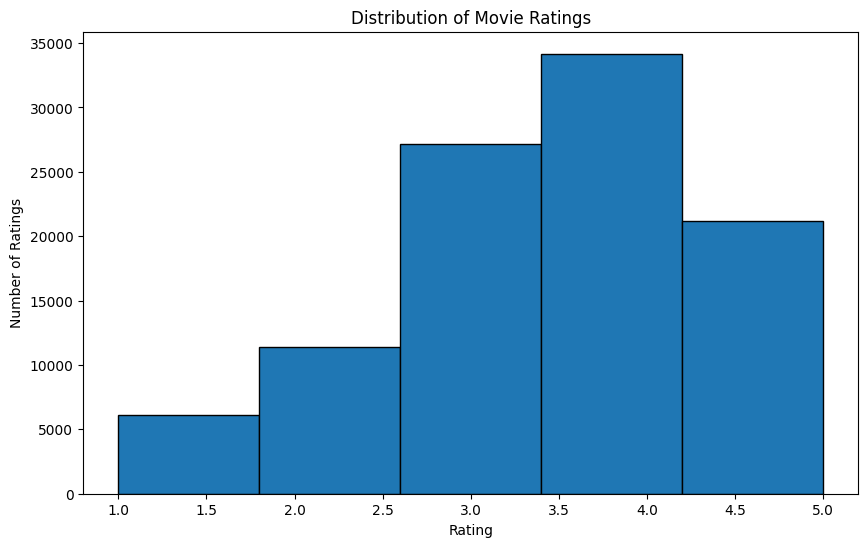

In [ ]:
# Plot distribution of movie ratings
plt.figure(figsize=(10, 6))
plt.hist(ratings_df['user_rating'], bins=5, edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

# Count number of movies per genre
genre_counts = movies_exploded['movie_genres'].value_counts()


 Plot number of movies per genre

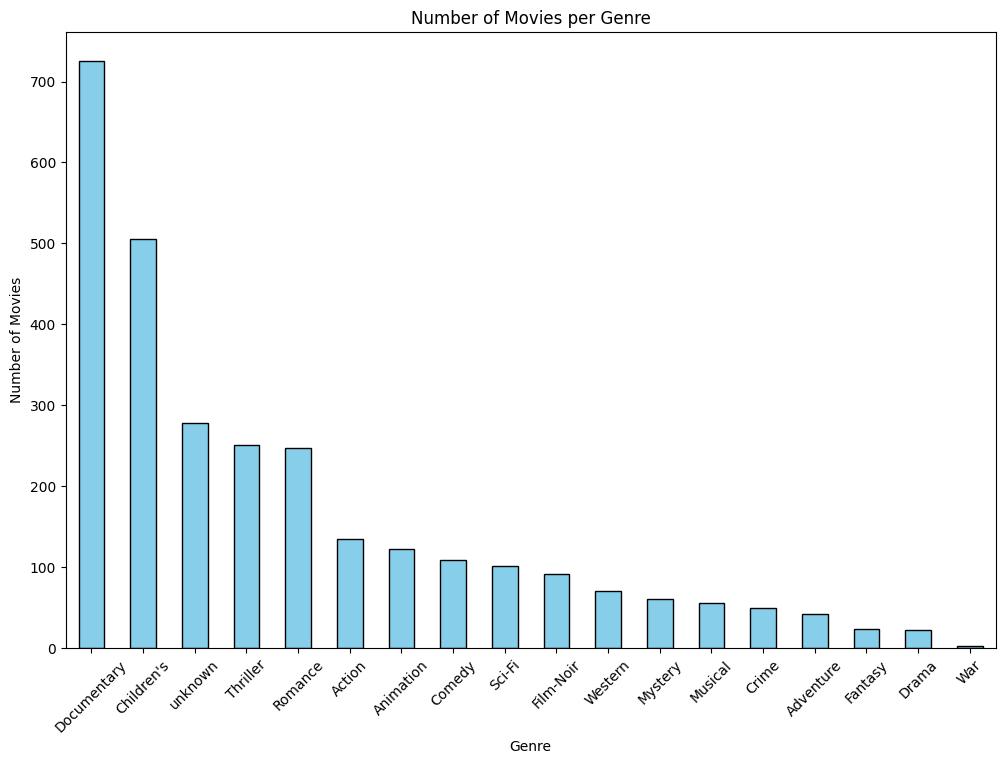

In [ ]:


plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

**Recommendation System 3: Average Movie Ratings Visualization**

Import and Install packages

In [6]:
# Install necessary packages
!pip install -q matplotlib pandas tensorflow-datasets

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds


Load the data

In [7]:

# Load the movie metadata and ratings
movies_data = tfds.load('movielens/100k-movies', split="train")
ratings_data = tfds.load('movielens/100k-ratings', split="train")

# Convert TensorFlow datasets to Pandas DataFrames
movies_df = tfds.as_dataframe(movies_data)
ratings_df = tfds.as_dataframe(ratings_data)


 Extract relevant columns

In [8]:


ratings_df = ratings_df[['movie_id', 'user_rating']]

# Group ratings by movie and calculate average rating
movie_avg_ratings = ratings_df.groupby('movie_id')['user_rating'].mean().reset_index()

# Sample subset of movies with highest average ratings
top_rated_movies = movie_avg_ratings.nlargest(20, 'user_rating')  # Selecting top 20 highest rated movies

# Sort by movie ID for a meaningful line graph
top_rated_movies = top_rated_movies.sort_values(by='movie_id')


Plot distribution

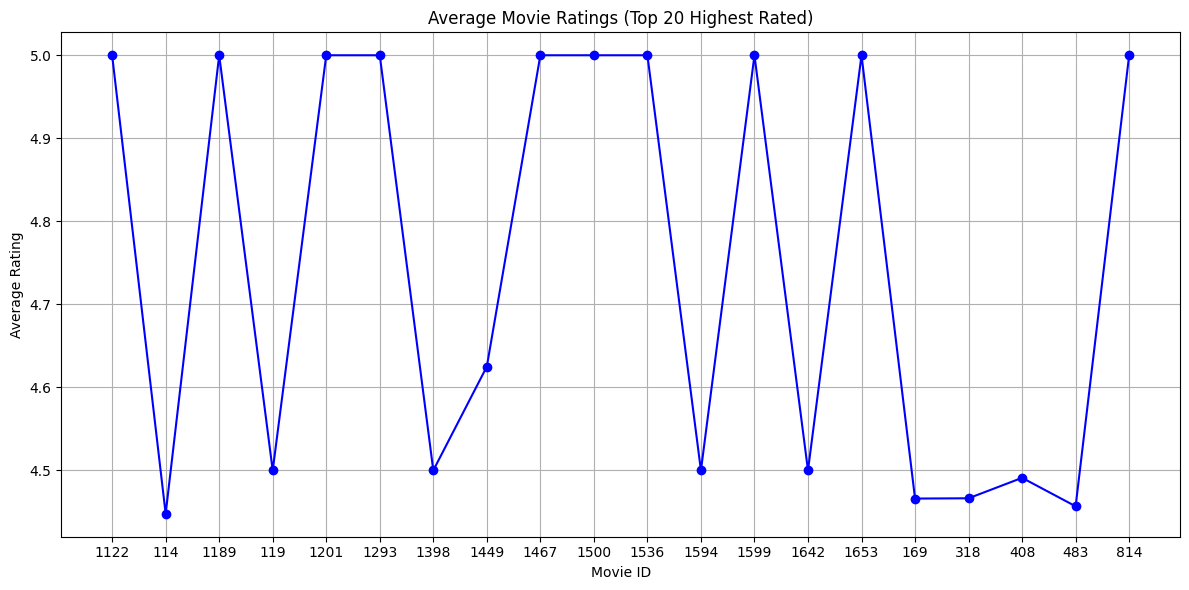

In [9]:

# Plot line graph of average ratings over movie IDs
plt.figure(figsize=(12, 6))
plt.plot(top_rated_movies['movie_id'], top_rated_movies['user_rating'], marker='o', linestyle='-', color='b')
plt.title('Average Movie Ratings (Top 20 Highest Rated)')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()
